# Rapport 12/23/2023

## Population des armoires étuves

On identifie 3 populations d'étuves:
- 1. Monobloc
- 2. Modulaire basse température et 1 moteur soufflage
- 3. Modulaire haute température et 2 moteurs soufflage

Pour les identifier on utilise les codes "ADV":

- ADV-ETUVE-MONO -> Monobloc
- ADV-ETUVE-MOD-BT -> Modulaire basse température
- ADV-ETUVE-MOD-HT -> Modulaire haute température

Et ensuite on trie par rapport au nombre de moteurs soufflage. Les étuves avec variateurs sont exclues.

In [72]:
# Quelques imports et code preliminaire

import pandas as pd
import matplotlib.pyplot as plt
from extract_info import get_armoires_etuves

def plot_concentric_bubbles(data, x, y, size, hue, max_hue=10, fig=None, ax=None):
    """
    Plots a bubble chart with concentric circles.

    Parameters:
    data (pd.DataFrame): The DataFrame containing the data.
    x (str): The column name for x-axis values.
    y (str): The column name for y-axis values.
    size (str): The column name for the size of the bubbles.
    hue (str): The column name for the hue of the bubbles.
    """
    # Sort data by hue
    import matplotlib

# Find hues and sort from most to least frequent
    hue_size = data.groupby(hue, as_index=False)[size].sum()
    hue_size = hue_size.sort_values(by=size, ascending=False)
    hue_order = hue_size[hue].values
    # map hue to integer
    hue2int = {hue: i for i, hue in enumerate(hue_order)}
    data['hue_int'] = data[hue].map(hue2int)
    data_sorted = data.sort_values(by='hue_int')

    #  Remove hues with low frequency
    if len(hue_order) > max_hue:
        hue_order = hue_order[:max_hue]
        data_sorted = data_sorted[data_sorted[hue].isin(hue_order)]
        data_sorted['hue_int'] = data_sorted[hue].map(hue2int)

    # Prepare figure
    if fig is None and ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(9, 6))

    #  Choose a color palette pastel
    colors = matplotlib.colormaps.get_cmap('Pastel2').colors

    # Iterate over each hue
    for hue_int in range(len(hue_order)):
        hue_value = hue_order[hue_int]
        hue_data = data_sorted[data_sorted['hue_int'] >= hue_int]

        # Cumulative sum for size within each (x, y) group
        to_plot = hue_data.groupby([x, y], as_index=False)[size].sum()
        # Modify size for best plot effect
        to_plot[size] = to_plot[size].apply(lambda x: 100*x**(1))
        # Scatter plot for each hue. linewidth is 0 to remove the line between points
        ax.scatter(to_plot[x], to_plot[y], s=to_plot[size], alpha=1, label=hue_value, linewidth=0, zorder=hue_int, color=colors[hue_int])


    # Calculate total sum of size for each (x, y) group and add as text
    totals = data.groupby([x, y], as_index=False)[size].sum()
    for i, txt in enumerate(totals[size]):
        ax.text(totals[x].iloc[i], totals[y].iloc[i], txt, ha='center', va='center', color='black', zorder=len(hue_order)+1)

    ax.set_xlabel(x)
    ax.set_ylabel(y)
    # Customize and place legend outside the plot
    legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Make all legend markers the same size
    for handle in legend.legend_handles:
        handle.set_sizes([100])
    return fig, ax

def plot_bubble_price(data, x, y, size, label, fig=None, ax=None):
    """
    Plots a bubble chart with prices

    Parameters:
    data (pd.DataFrame): The DataFrame containing the data.
    x (str): The column name for x-axis values.
    y (str): The column name for y-axis values.
    size (str): The column name for the size of the bubbles.
    hue (str): The column name for the annotation
    """
    # Sort data by hue
    import matplotlib

    # Prepare figure
    if fig is None and ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(9, 9))

    #  Choose a color palette pastel
    colors = matplotlib.colormaps.get_cmap('Pastel2').colors
    ax.scatter(data[x], data[y], s=data[size]*50, alpha=1, linewidth=0, color=colors[0])
    # Add label as annotation in the plot
    for i, txt in enumerate(data[label]):
        ax.text(data[x].iloc[i], data[y].iloc[i], txt, ha='center', va='center', color='black', zorder=len(data)+1)
    return fig, ax

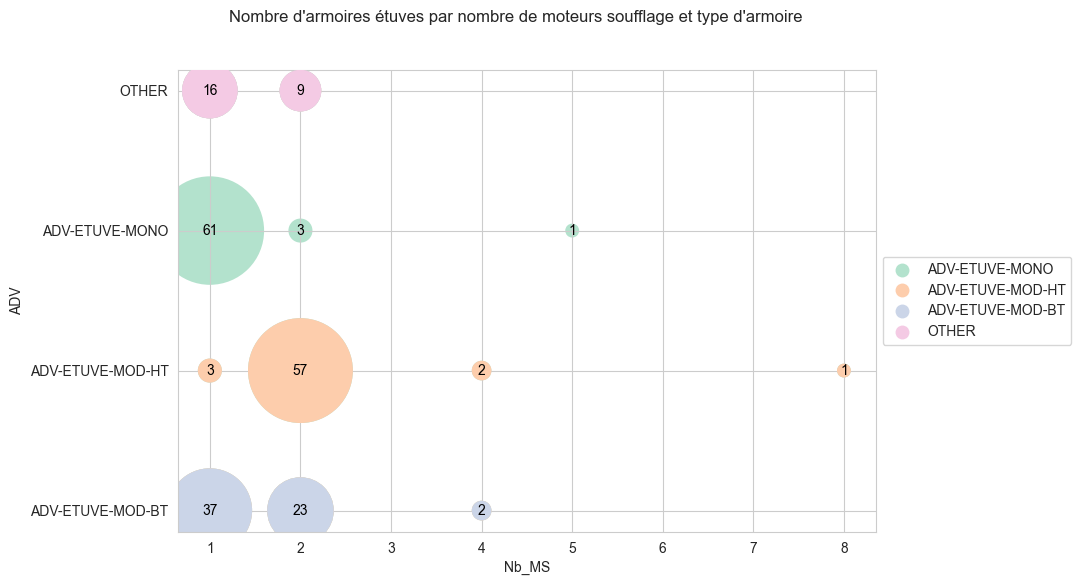

In [73]:
df_etuve = get_armoires_etuves(cache=False)
df_etuve = df_etuve[~df_etuve['Dem_Mot'].str.contains('ariate')]

adv_classes = ["ADV-ETUVE-MOD-BT", "ADV-ETUVE-MOD-HT", "ADV-ETUVE-MONO"]

#  Rename ADV classes not in the list with 'OTHER'
df_etuve.loc[~df_etuve['ADV'].isin(adv_classes), 'ADV'] = 'OTHER'

distinct_cases = df_etuve.groupby(['Nb_MS', 'ADV'], as_index=False)['Num_AF'].count()
distinct_cases
fig, ax = plot_concentric_bubbles(distinct_cases, 'Nb_MS', 'ADV', 'Num_AF', 'ADV', max_hue=10)
fig.suptitle("Nombre d'armoires étuves par nombre de moteurs soufflage et type d'armoire")
plt.show();

On exporte les données dans un fichier excel (`\temp\etuve.xlsx`)

In [74]:
df_etuve_xlsx = get_armoires_etuves(cache=False)


columns = ['Code_Equip', 'Date', 'Caract', 'Nb_MS', 'MS1', 'MS2', 'ME1',
           'Dem_Mot', 'Chauff', 'Regul', 'ADV', 'puissance_bruleur', 'qty_bruleur', 'armoire_price']

#  COnvert ot int, including NAN
df_etuve_xlsx['armoire_price'] = df_etuve_xlsx['armoire_price'].fillna(0).astype(int)

# Export to xls
filename = f'./temp/etuve.xlsx'
writer = pd.ExcelWriter(filename, engine='openpyxl')

# MOD-HT
df = df_etuve_xlsx[df_etuve_xlsx['ADV'] == "ADV-ETUVE-MOD-HT"].copy()
# Create a sheet 'MOD-HT'
writer.sheets['MOD-HT'] = df.to_excel(writer, sheet_name='MOD-HT', index=False)

# MOD-BT
df = df_etuve_xlsx[df_etuve_xlsx['ADV'] == "ADV-ETUVE-MOD-BT"].copy()
# Create a sheet 'MOD-BT'
writer.sheets['MOD-BT'] = df.to_excel(writer, sheet_name='MOD-BT', index=False)

# MONO
df = df_etuve_xlsx[df_etuve_xlsx['ADV'] == "ADV-ETUVE-MONO"].copy()
# Create a sheet 'MONO'
writer.sheets['MONO'] = df.to_excel(writer, sheet_name='MONO', index=False)

# Remaining
df = df_etuve_xlsx[~df_etuve_xlsx['ADV'].isin(["ADV-ETUVE-MOD-HT", "ADV-ETUVE-MOD-BT", "ADV-ETUVE-MONO"])].copy()
# Create a sheet 'MONO'

writer.sheets['OTHER'] = df.to_excel(writer, sheet_name='OTHER', index=False)

writer.close()

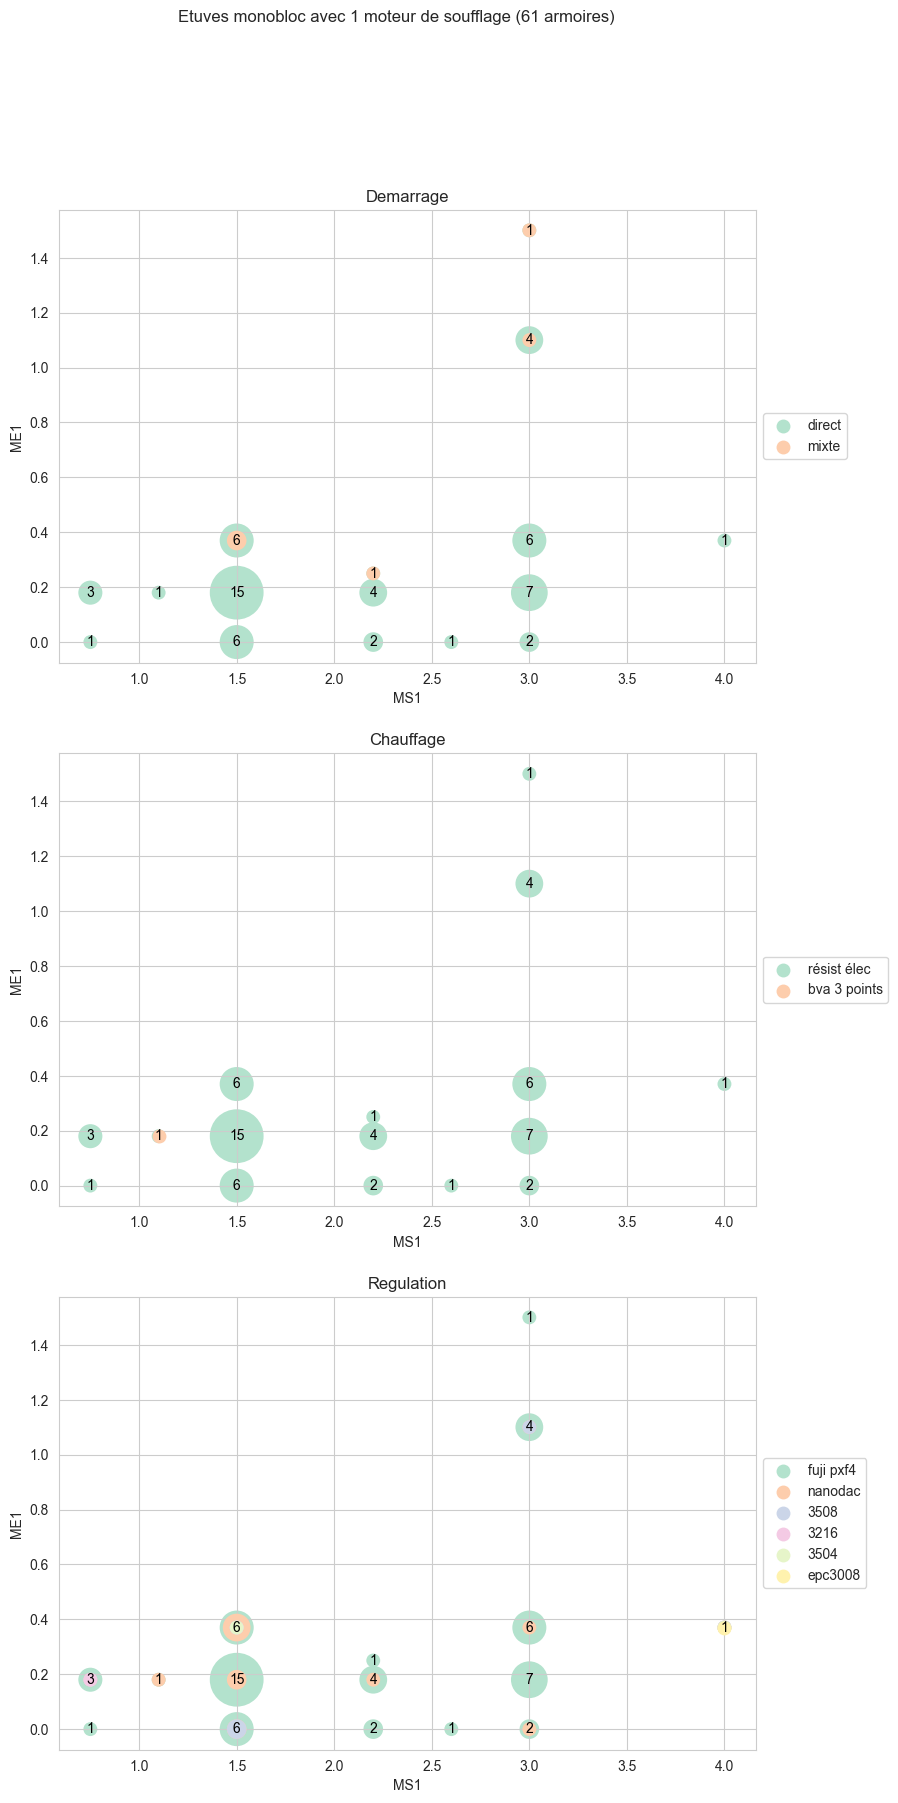

In [75]:
# ╔╦╗╔═╗╔╗╔╔═╗╔╗ ╦  ╔═╗╔═╗
# ║║║║ ║║║║║ ║╠╩╗║  ║ ║║
# ╩ ╩╚═╝╝╚╝╚═╝╚═╝╩═╝╚═╝╚═╝
df = df_etuve[df_etuve['ADV'] == 'ADV-ETUVE-MONO'].copy()
# Replace no ME1 by 0
df['ME1'] = df['ME1'].fillna(0)
# 1 seul moteur de soufflage
df = df[df['Nb_MS'] == 1]


fig, ax = plt.subplots(3, 1, figsize=(9, 20))

distinct_cases = df.groupby(['MS1', 'ME1', 'Dem_Mot'], as_index=False)['Num_AF'].count()
plot_concentric_bubbles(distinct_cases, 'MS1', 'ME1', 'Num_AF', 'Dem_Mot', max_hue=10, fig=fig, ax=ax[0])

distinct_cases = df.groupby(['MS1', 'ME1', 'Chauff'], as_index=False)['Num_AF'].count()
plot_concentric_bubbles(distinct_cases, 'MS1', 'ME1', 'Num_AF', 'Chauff', max_hue=10, fig=fig, ax=ax[1])

distinct_cases = df.groupby(['MS1', 'ME1', 'Regul'], as_index=False)['Num_AF'].count()
plot_concentric_bubbles(distinct_cases, 'MS1', 'ME1', 'Num_AF', 'Regul', max_hue=10, fig=fig, ax=ax[2])
fig.suptitle(f"Etuves monobloc avec 1 moteur de soufflage ({len(df)} armoires)")
ax[0].set_title("Demarrage")
ax[1].set_title("Chauffage")
ax[2].set_title("Regulation")
plt.show();

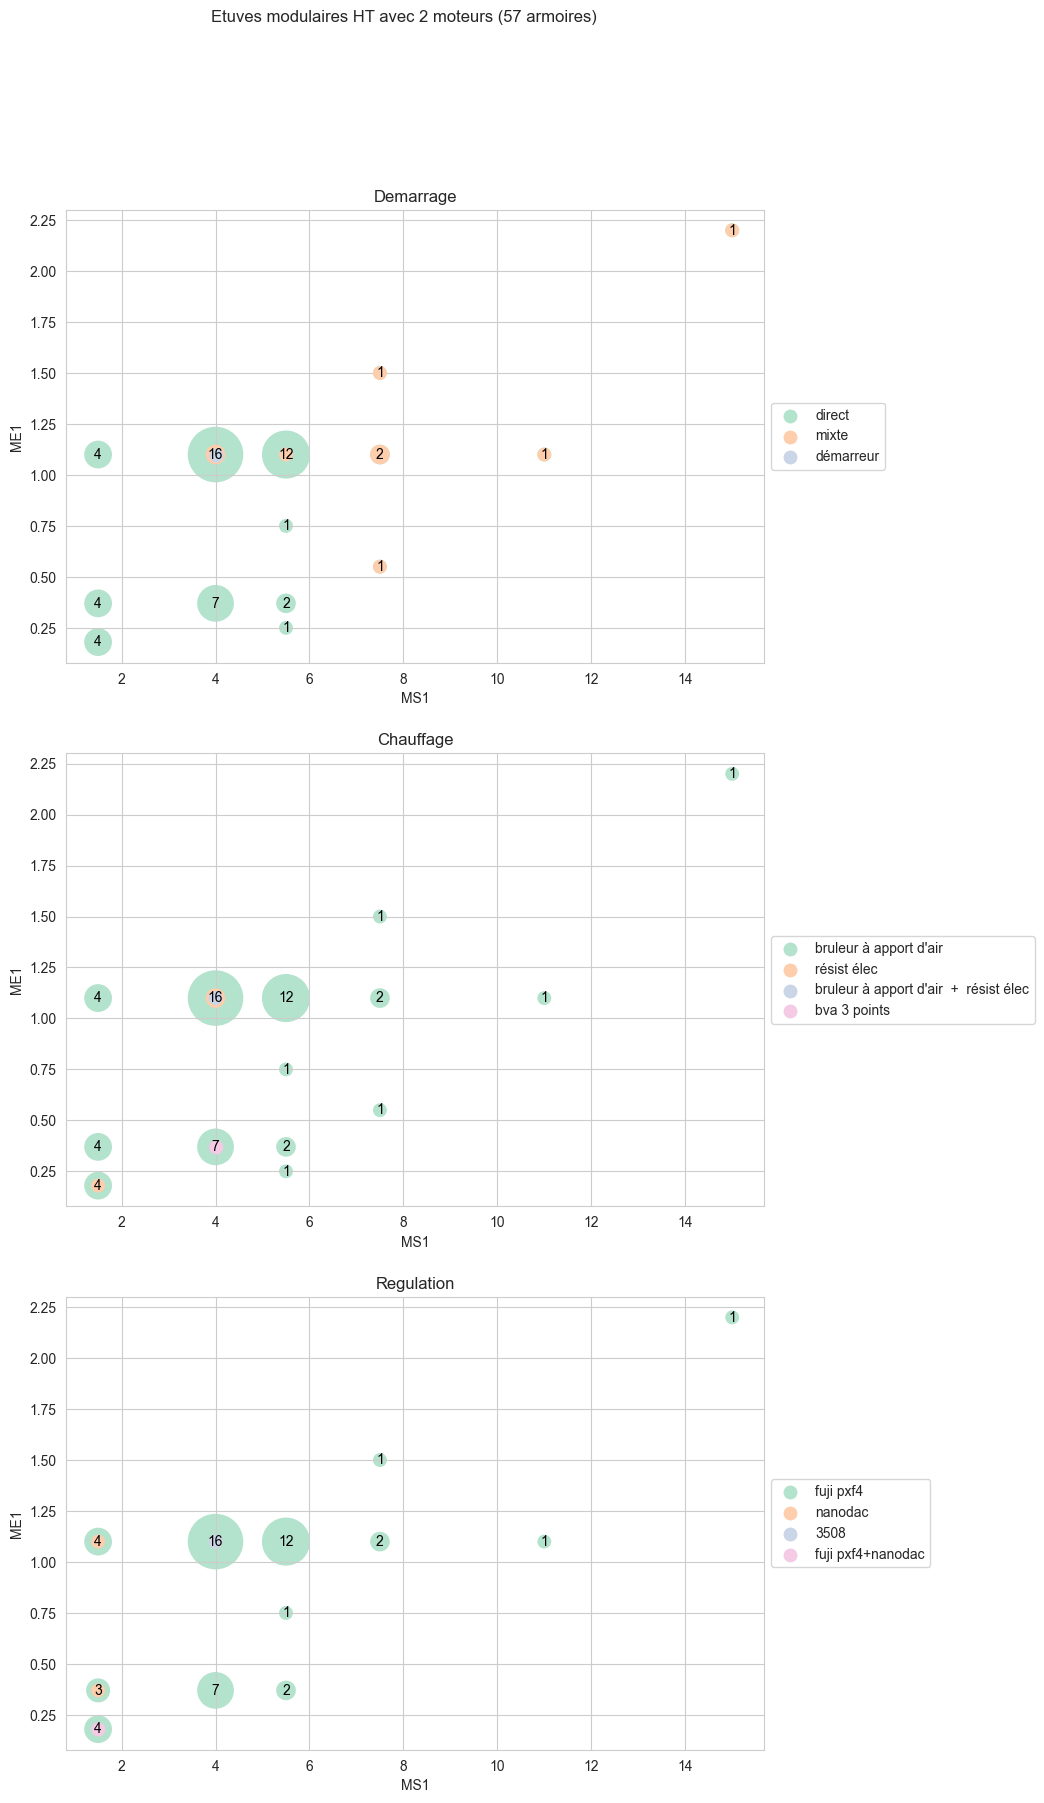

In [76]:
# ╔╦╗╔═╗╔╦╗╦ ╦╦     ╦ ╦╔╦╗
# ║║║║ ║ ║║║ ║║     ╠═╣ ║
# ╩ ╩╚═╝═╩╝╚═╝╩═╝o  ╩ ╩ ╩
df = df_etuve[df_etuve['ADV'] == 'ADV-ETUVE-MOD-HT'].copy()
# Replace no ME1 by 0
df['ME1'] = df['ME1'].fillna(0)
# 1 seul moteur de soufflage
df = df[df['Nb_MS'] == 2]


fig, ax = plt.subplots(3, 1, figsize=(9, 20))

distinct_cases = df.groupby(['MS1', 'ME1', 'Dem_Mot'], as_index=False)['Num_AF'].count()
plot_concentric_bubbles(distinct_cases, 'MS1', 'ME1', 'Num_AF', 'Dem_Mot', max_hue=10, fig=fig, ax=ax[0])

distinct_cases = df.groupby(['MS1', 'ME1', 'Chauff'], as_index=False)['Num_AF'].count()
plot_concentric_bubbles(distinct_cases, 'MS1', 'ME1', 'Num_AF', 'Chauff', max_hue=10, fig=fig, ax=ax[1])

distinct_cases = df.groupby(['MS1', 'ME1', 'Regul'], as_index=False)['Num_AF'].count()
plot_concentric_bubbles(distinct_cases, 'MS1', 'ME1', 'Num_AF', 'Regul', max_hue=10, fig=fig, ax=ax[2])
fig.suptitle(f"Etuves modulaires HT avec 2 moteurs ({len(df)} armoires)")
ax[0].set_title("Demarrage")
ax[1].set_title("Chauffage")
ax[2].set_title("Regulation")
plt.show();

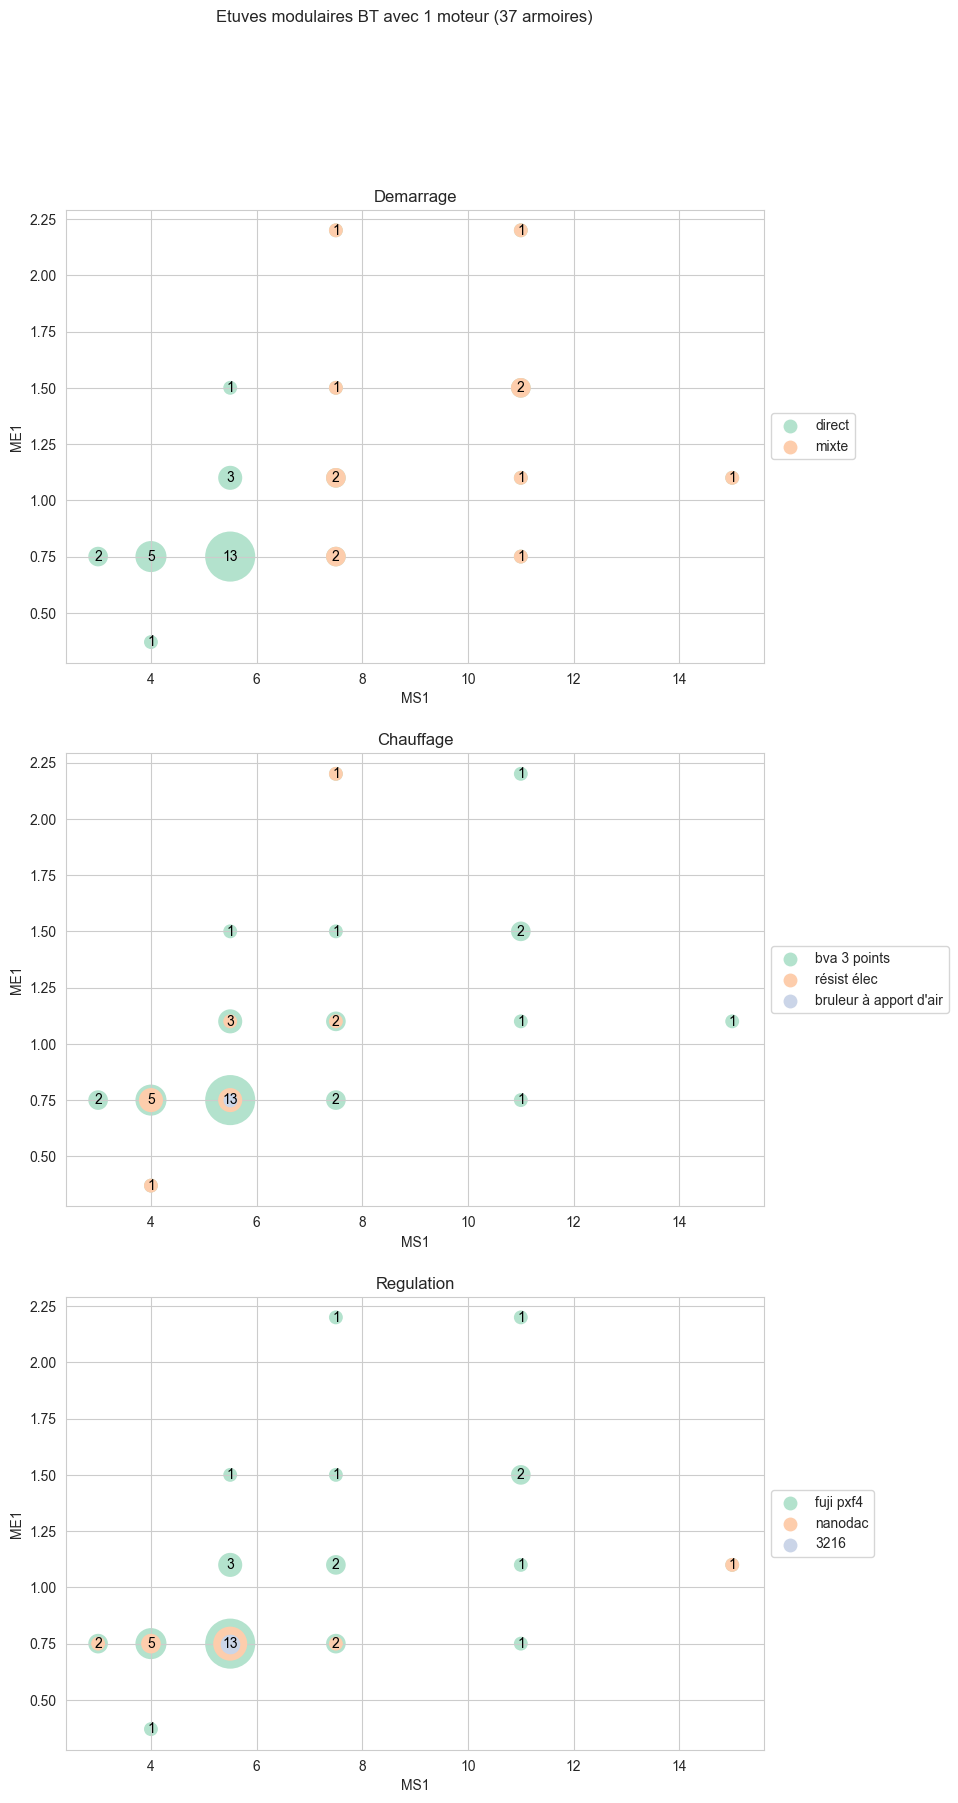

In [77]:
# ╔╦╗╔═╗╔╦╗╦ ╦╦     ╔╗╔╦╗
# ║║║║ ║ ║║║ ║║     ╠╩╗║
# ╩ ╩╚═╝═╩╝╚═╝╩═╝o  ╚═╝╩

df = df_etuve[df_etuve['ADV'] == 'ADV-ETUVE-MOD-BT'].copy()
# Replace no ME1 by 0
df['ME1'] = df['ME1'].fillna(0)
# 1 seul moteur de soufflage
df = df[df['Nb_MS'] == 1]


fig, ax = plt.subplots(3, 1, figsize=(9, 20))

distinct_cases = df.groupby(['MS1', 'ME1', 'Dem_Mot'], as_index=False)['Num_AF'].count()
plot_concentric_bubbles(distinct_cases, 'MS1', 'ME1', 'Num_AF', 'Dem_Mot', max_hue=10, fig=fig, ax=ax[0])

distinct_cases = df.groupby(['MS1', 'ME1', 'Chauff'], as_index=False)['Num_AF'].count()
plot_concentric_bubbles(distinct_cases, 'MS1', 'ME1', 'Num_AF', 'Chauff', max_hue=10, fig=fig, ax=ax[1])

distinct_cases = df.groupby(['MS1', 'ME1', 'Regul'], as_index=False)['Num_AF'].count()
plot_concentric_bubbles(distinct_cases, 'MS1', 'ME1', 'Num_AF', 'Regul', max_hue=10, fig=fig, ax=ax[2])
fig.suptitle(f"Etuves modulaires BT avec 1 moteur ({len(df)} armoires)")
ax[0].set_title("Demarrage")
ax[1].set_title("Chauffage")
ax[2].set_title("Regulation")
plt.show();

## Prix des armoires

Les prix sont récupéres de AX. Pour les moteurs nous obtenons les prix suivants:


![Source](plots/price_motor.png)

On peut aussi récupérer directement le prix de l'armoire complet.

A premier vue, le prix de l'armoire ne semble pas dependre strictement de la puissance des moteurs ou type de régulation/chauffage.

On peut le voir dans l'exemple suivant, sur les étuves modulaire à haute température avec 2 moteurs de soufflage (je considère uniquement les cas où le prix a pu être récupéré).

Le montant affiché est le prix moyen par cluster, avec son ecart type (dans une distribution normale 70% des valeurs sont dans l'intervalle [moyenne-ecart_type, moyenne+ecart_type]).

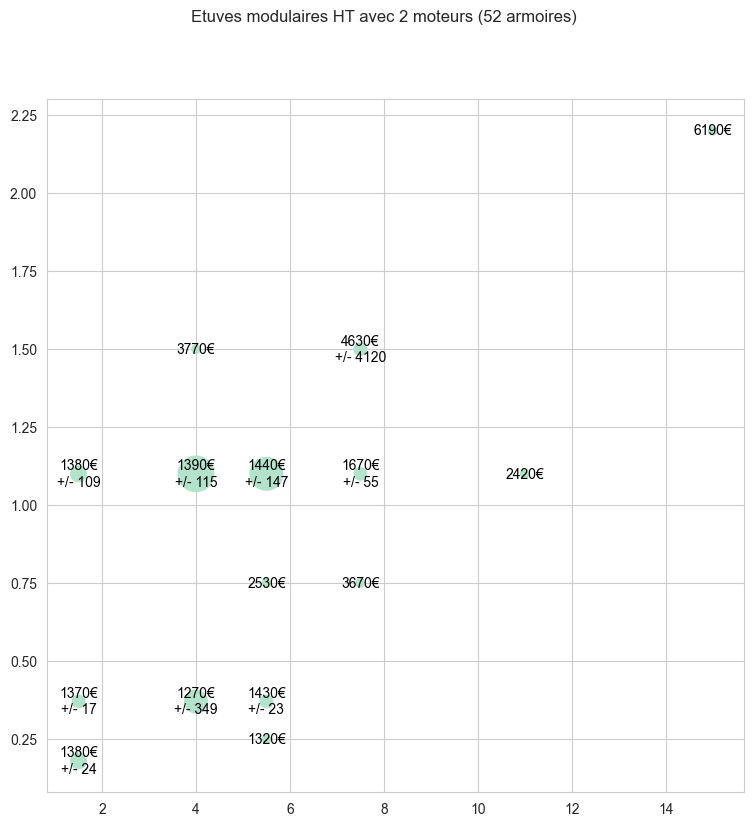

In [78]:
df = df_etuve[df_etuve['ADV'] == 'ADV-ETUVE-MOD-HT'].copy()
#  Remove where price is 0
df = df[df['armoire_price'] > 0]
# Replace no ME1 by 0
df['ME1'] = df['ME1'].fillna(0)

# Filter by Regul
df = df[df['Regul'].str.lower().str.strip() == 'fuji pxf4']
#  Filter by chauffage
df = df[df['Chauff'].str.lower().str.strip() == "bruleur à apport d'air"]

distinct_cases = df.groupby(['MS1', 'ME1'], as_index=False).agg(
    {'Num_AF': 'count', 'armoire_price': ['mean', 'std', 'max', 'min']}
    )


# fig, ax = plot_concentric_bubbles(distinct_cases, 'MS1', 'ME1', 'Num_AF', 'Chauff')

distinct_cases['mean_price'] = distinct_cases['armoire_price']['mean'].apply(lambda x: round(x, -1)).astype(int)
distinct_cases['std_label'] = distinct_cases['armoire_price']['std'].apply(lambda x: f"\n+/- {x:.0f}" if not pd.isna(x) else '')
distinct_cases['label'] = distinct_cases['mean_price'].astype(str)+'€' + distinct_cases['std_label'].astype(str)

fig, ax = plot_bubble_price(distinct_cases, 'MS1', 'ME1', 'Num_AF', 'label')
fig.suptitle(f"Etuves modulaires HT avec 2 moteurs ({len(df)} armoires)")
plt.show();

Il avait été envisagé d'utiliser les prix moyens des armoires pour estimer le coût d'un remplacement d'armoire, mais les prix sont clairement trop variables pour être utilisés de cette manière.

Il est possible que cela soit du au nombre reduit d'armoires dans chaque cluster, j'ai donc essayé un autre approche. Au lieu de prendre le prix moyen par armoire complet, j'ai essayer de determiner l'impact des differents composants sur le prix complet de l'armoire.

J'ai utilisé à ce fin une regression linéaire avec un Lasso pour la régularisation. (Le Lasso est une méthode pour simplifier les modèles de regression en supprimant les variables qui ont un faible impact sur le résultat).
Pour estimer la fiabilité du modèle, j'ai utilisé la méthode de cross-validation. (Le principe est de diviser les données en 2 groupes: un groupe d'entrainement et un groupe de test. Le modèle est entrainé sur le groupe d'entrainement et testé sur le groupe de test. On répète l'opération plusieurs fois en changeant les groupes d'entrainement et de test. On obtient ainsi une estimation de la fiabilité du modèle. Ce qu'il faut retenir est que le modèle est testé sur un groupe de données qu'il n'a pas vu pendant l'entrainement, ce qui rend cette approche assez fiable pour notre cas d'usage).

Les predicteurs suivants ont été testé :
- Puissance soufflage
- Puissance extraction
- Nombre de cabines identiques
- Type de régulation
- Type de chauffage
- Année de fabrication
- Volume de l'armoire

Voici les résultats obtenus sur les trois types d'armoires:

Nbre d'étuves: 38
Mean MSE: 0.17606250358724396
R2: 0.823937496412756
Mean absolute error: 400 €


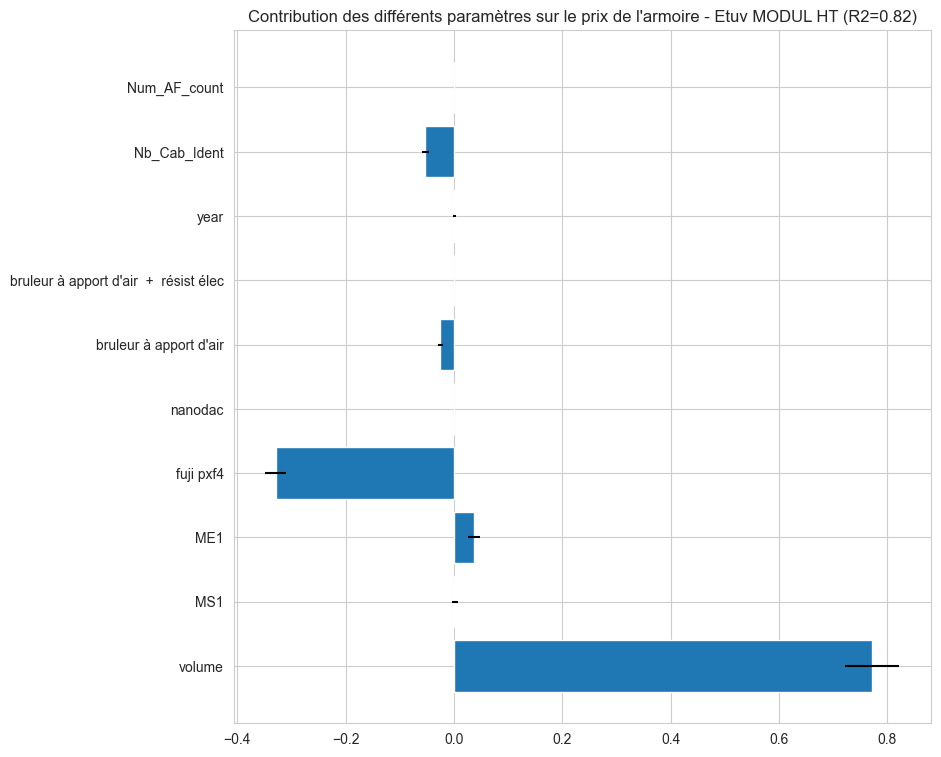

In [79]:
# On essaye de filtrer les monoblocs:
df = df_etuve[df_etuve['ADV'] == 'ADV-ETUVE-MOD-HT'].copy()
#  2 moteurs de soufflage
df = df[df['Nb_MS'] == 2]

# Get nomber of armoire for each cluster
distinct_cases = df.groupby(['MS1', 'ME1'], as_index=False)['Num_AF'].count()
# Join with df
df = df.merge(distinct_cases, on=['MS1', 'ME1'], how='left', suffixes=('', '_count'))
#  Remove where price is 0
df = df[df['armoire_price'] > 0]
# Replace no ME1 by 0
df['ME1'] = df['ME1'].fillna(0)

# Make a dummy field from Regul (there are many different values)

from sklearn.preprocessing import OneHotEncoder

# Add a column with year
df['year'] = df['Date'].dt.year

#  Remove rows where dimensions are not available
df = df[~df['Length'].isna()]

df['volume'] = df['Length'] * df['Width'] * df['Height']

print(f"Nbre d'étuves: {len(df)}")

# Create an instance of the OneHotEncoder

enc1 = OneHotEncoder(handle_unknown='ignore')
# Apply the encoder to the df
OH_Reg = enc1.fit_transform(df['Regul'].str.lower().str.strip().values.reshape(-1, 1)).toarray()
#  Print alternative categories
# print(enc1.categories_)
enc2 = OneHotEncoder(handle_unknown='ignore')
OH_Chauff = enc2.fit_transform(df['Chauff'].str.lower().str.strip().values.reshape(-1, 1)).toarray()
#  Print alternative categories
# print(enc2.categories_)

# Train a linear regression with lasso to infer the price of the armoire
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_validate
import numpy as np

# Use a k-fold cross validation to find the best alpha

y = df['armoire_price'].values

X = df[['volume']].values
# X = df[['ME1']].values
X = np.concatenate((X, df[['MS1', 'ME1']].values), axis=1)
# Add OH encoding
X = np.concatenate((X, OH_Reg), axis=1)
X = np.concatenate((X, OH_Chauff), axis=1)
X = np.concatenate((X, df['year'].values.reshape(-1, 1)), axis=1)
X = np.concatenate((X, df['Nb_Cab_Ident'].values.reshape(-1, 1)), axis=1)
X = np.concatenate((X, df['Num_AF_count'].values.reshape(-1, 1)), axis=1)
# X = np.concatenate((X, df[['Length', 'Width', 'Height']].values), axis=1)

#  Normalize data
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
y_std = np.std(y)
y = (y - np.mean(y)) / y_std

#  Model is lasso with intercept
model = Lasso(fit_intercept=True, alpha=0.05)

# Model is knn
from sklearn.neighbors import KNeighborsRegressor
# model = KNeighborsRegressor(n_neighbors=5)

# Take just Dummy regressor with mean
from sklearn.dummy import DummyRegressor
# model = DummyRegressor(strategy='mean')

# Define a leave 2 out cross validation
from sklearn.model_selection import LeavePOut

cv = LeavePOut(p=1)

# Perform cross-validation
cv_results = cross_validate(model, X, y, cv=cv, return_estimator=True, scoring='neg_mean_squared_error')

# Extract R2 scores
nmse_scores = cv_results['test_score']

# Extract coefficients
coefficients = np.array([estimator.coef_ for estimator in cv_results['estimator']])

# Calculate the mean and standard deviation of the coefficients
mean_coefficients = np.mean(coefficients, axis=0)
std_coefficients = np.std(coefficients, axis=0)

# Print results
mean_mse = np.mean(-nmse_scores)
print("Mean MSE:", mean_mse)
r2 = 1 - mean_mse / np.var(y)
print("R2:", r2)
# print("Mean coefficients:", mean_coefficients)
# print("Standard deviation of coefficients:", std_coefficients)
mean_err_euros = np.abs(mean_mse) ** 0.5 * y_std
print(f"Mean absolute error: {mean_err_euros:.0f} €")
# Make a plot of contribution of different coefficients
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
ax.barh(np.arange(len(mean_coefficients)), mean_coefficients, xerr=std_coefficients)
ax.set_yticks(np.arange(len(mean_coefficients)))
labels = ['volume', 'MS1', 'ME1'] + list(enc1.categories_[0]) + list(enc2.categories_[0]) + ['year', 'Nb_Cab_Ident',
                                                                                             'Num_AF_count']
ax.set_yticklabels(labels)
ax.set_title(f"Contribution des différents paramètres sur le prix de l'armoire - Etuv MODUL HT (R2={r2:.2f})")
plt.show();


Nbre d'étuves: 27
Mean MSE: 0.05960665680937089
R2: 0.9403933431906291
Mean absolute error: 348 €


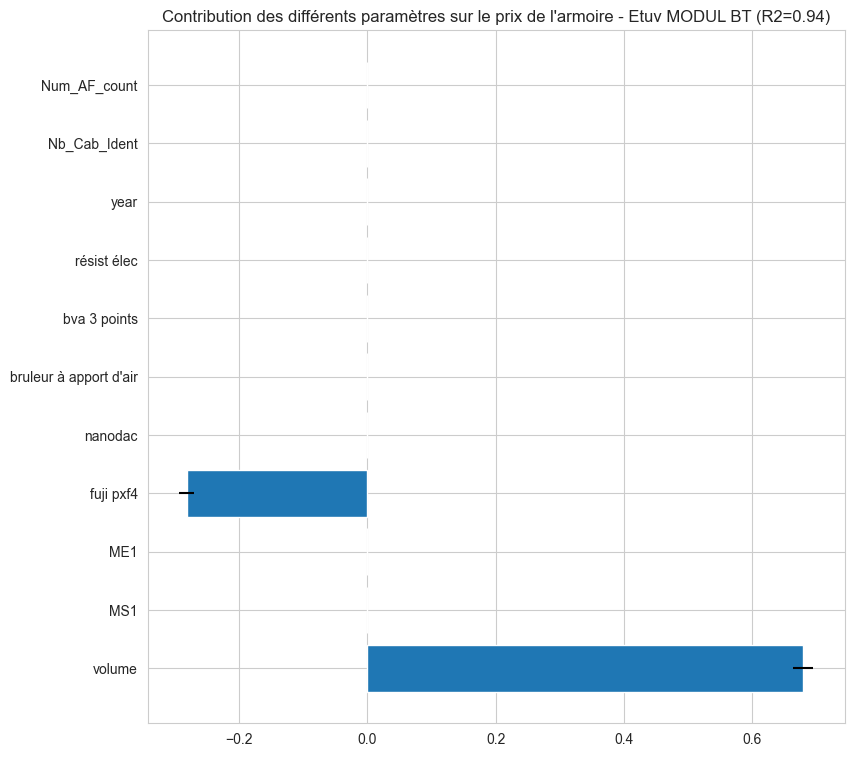

In [80]:
plt.show();
# ╔╦╗╔═╗╔╦╗╦ ╦╦     ╔╗╔╦╗
# ║║║║ ║ ║║║ ║║     ╠╩╗║
# ╩ ╩╚═╝═╩╝╚═╝╩═╝o  ╚═╝╩
# On essaye de filtrer les monoblocs:
df = df_etuve[df_etuve['ADV'] == 'ADV-ETUVE-MOD-BT'].copy()
#  2 moteurs de soufflage
df = df[df['Nb_MS'] == 1]

# Get nomber of armoire for each cluster
distinct_cases = df.groupby(['MS1', 'ME1'], as_index=False)['Num_AF'].count()
# Join with df
df = df.merge(distinct_cases, on=['MS1', 'ME1'], how='left', suffixes=('', '_count'))
#  Remove where price is 0
df = df[df['armoire_price'] > 0]
# Replace no ME1 by 0
df['ME1'] = df['ME1'].fillna(0)

# Make a dummy field from Regul (there are many different values)

from sklearn.preprocessing import OneHotEncoder

# Add a column with year
df['year'] = df['Date'].dt.year

#  Remove rows where dimensions are not available
df = df[~df['Length'].isna()]

df['volume'] = df['Length'] * df['Width'] * df['Height']

print(f"Nbre d'étuves: {len(df)}")

# Create an instance of the OneHotEncoder

enc1 = OneHotEncoder(handle_unknown='ignore')
# Apply the encoder to the df
OH_Reg = enc1.fit_transform(df['Regul'].str.lower().str.strip().values.reshape(-1, 1)).toarray()
#  Print alternative categories
# print(enc1.categories_)
enc2 = OneHotEncoder(handle_unknown='ignore')
OH_Chauff = enc2.fit_transform(df['Chauff'].str.lower().str.strip().values.reshape(-1, 1)).toarray()
#  Print alternative categories
# print(enc2.categories_)

# Train a linear regression with lasso to infer the price of the armoire
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_validate
import numpy as np

# Use a k-fold cross validation to find the best alpha

y = df['armoire_price'].values

X = df[['volume']].values
# X = df[['ME1']].values
X = np.concatenate((X, df[['MS1', 'ME1']].values), axis=1)
# Add OH encoding
X = np.concatenate((X, OH_Reg), axis=1)
X = np.concatenate((X, OH_Chauff), axis=1)
X = np.concatenate((X, df['year'].values.reshape(-1, 1)), axis=1)
X = np.concatenate((X, df['Nb_Cab_Ident'].values.reshape(-1, 1)), axis=1)
X = np.concatenate((X, df['Num_AF_count'].values.reshape(-1, 1)), axis=1)
# X = np.concatenate((X, df[['Length', 'Width', 'Height']].values), axis=1)

#  Normalize data
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
y_std = np.std(y)
y = (y - np.mean(y)) / y_std

#  Model is lasso with intercept
model = Lasso(fit_intercept=True, alpha=0.1)

# Model is knn
from sklearn.neighbors import KNeighborsRegressor
# model = KNeighborsRegressor(n_neighbors=5)

# Take just Dummy regressor with mean
from sklearn.dummy import DummyRegressor
# model = DummyRegressor(strategy='mean')

# Define a leave 2 out cross validation
from sklearn.model_selection import LeavePOut

cv = LeavePOut(p=1)

# Perform cross-validation
cv_results = cross_validate(model, X, y, cv=cv, return_estimator=True, scoring='neg_mean_squared_error')

# Extract R2 scores
nmse_scores = cv_results['test_score']

# Extract coefficients
coefficients = np.array([estimator.coef_ for estimator in cv_results['estimator']])

# Calculate the mean and standard deviation of the coefficients
mean_coefficients = np.mean(coefficients, axis=0)
std_coefficients = np.std(coefficients, axis=0)

# Print results
mean_mse = np.mean(-nmse_scores)
print("Mean MSE:", mean_mse)
r2 = 1 - mean_mse / np.var(y)
print("R2:", r2)
# print("Mean coefficients:", mean_coefficients)
# print("Standard deviation of coefficients:", std_coefficients)
mean_err_euros = np.abs(mean_mse) ** 0.5 * y_std
print(f"Mean absolute error: {mean_err_euros:.0f} €")
# Make a plot of contribution of different coefficients
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
ax.barh(np.arange(len(mean_coefficients)), mean_coefficients, xerr=std_coefficients)
ax.set_yticks(np.arange(len(mean_coefficients)))
labels = ['volume', 'MS1', 'ME1'] + list(enc1.categories_[0]) + list(enc2.categories_[0]) + ['year', 'Nb_Cab_Ident',
                                                                                             'Num_AF_count']
ax.set_yticklabels(labels)
ax.set_title(f"Contribution des différents paramètres sur le prix de l'armoire - Etuv MODUL BT (R2={r2:.2f})")
plt.show();


Nbre d'étuves: 37
Mean MSE: 0.6596963997356318
R2: 0.34030360026436823
Mean absolute error: 839 €


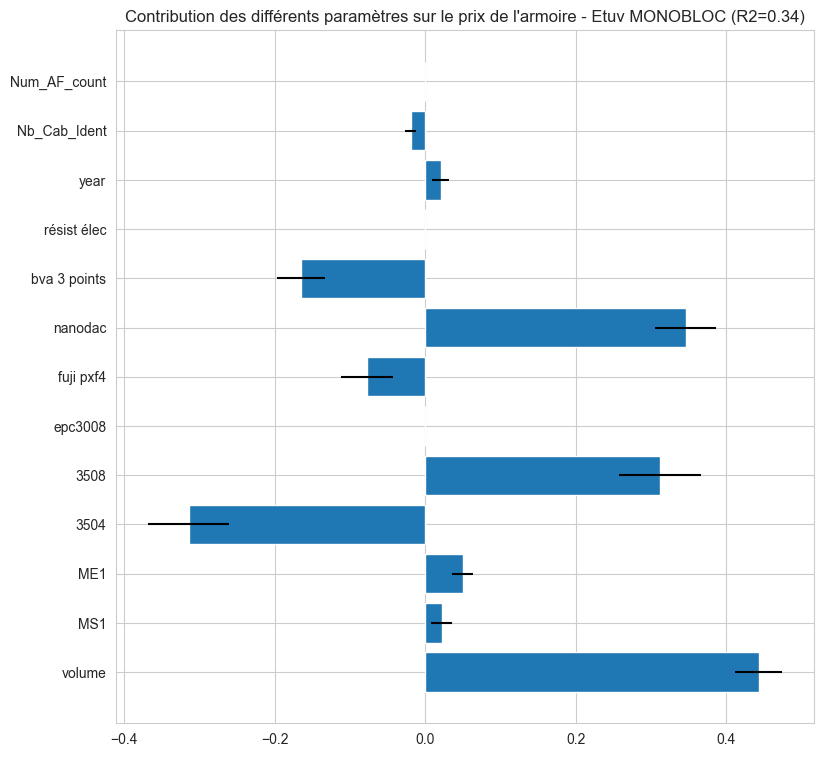

In [81]:
# ╔╦╗╔═╗╔╗╔╔═╗╔╗ ╦  ╔═╗╔═╗
# ║║║║ ║║║║║ ║╠╩╗║  ║ ║║
# ╩ ╩╚═╝╝╚╝╚═╝╚═╝╩═╝╚═╝╚═╝

# On essaye de filtrer les monoblocs:
df = df_etuve[df_etuve['ADV'] == 'ADV-ETUVE-MONO'].copy()
#  2 moteurs de soufflage
df = df[df['Nb_MS'] == 1]

# Replace no ME1 by 0
df['ME1'] = df['ME1'].fillna(0)

# Get nomber of armoire for each cluster
distinct_cases = df.groupby(['MS1', 'ME1'], as_index=False)['Num_AF'].count()
# Join with df
df = df.merge(distinct_cases, on=['MS1', 'ME1'], how='left', suffixes=('', '_count'))
#  Remove where price is 0
df = df[df['armoire_price'] > 0]


# Make a dummy field from Regul (there are many different values)

from sklearn.preprocessing import OneHotEncoder

# Add a column with year
df['year'] = df['Date'].dt.year

#  Remove rows where dimensions are not available
df = df[~df['Length'].isna()]

df['volume'] = df['Length'] * df['Width'] * df['Height']

print(f"Nbre d'étuves: {len(df)}")

# Create an instance of the OneHotEncoder

enc1 = OneHotEncoder(handle_unknown='ignore')
# Apply the encoder to the df
OH_Reg = enc1.fit_transform(df['Regul'].str.lower().str.strip().values.reshape(-1, 1)).toarray()
#  Print alternative categories
# print(enc1.categories_)
enc2 = OneHotEncoder(handle_unknown='ignore')
OH_Chauff = enc2.fit_transform(df['Chauff'].str.lower().str.strip().values.reshape(-1, 1)).toarray()
#  Print alternative categories
# print(enc2.categories_)

# Train a linear regression with lasso to infer the price of the armoire
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_validate
import numpy as np

# Use a k-fold cross validation to find the best alpha

y = df['armoire_price'].values

X = df[['volume']].values
X = np.concatenate((X, df[['MS1', 'ME1']].values), axis=1)
# Add OH encoding
X = np.concatenate((X, OH_Reg), axis=1)
X = np.concatenate((X, OH_Chauff), axis=1)
X = np.concatenate((X, df['year'].values.reshape(-1, 1)), axis=1)
X = np.concatenate((X, df['Nb_Cab_Ident'].values.reshape(-1, 1)), axis=1)
X = np.concatenate((X, df['Num_AF_count'].values.reshape(-1, 1)), axis=1)
# X = np.concatenate((X, df[['Length', 'Width', 'Height']].values), axis=1)

#  Normalize data
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
y_std = np.std(y)
y = (y - np.mean(y)) / y_std

#  Model is lasso with intercept
model = Lasso(fit_intercept=True, alpha=0.05)

# Model is knn
from sklearn.neighbors import KNeighborsRegressor
# model = KNeighborsRegressor(n_neighbors=5)

# Take just Dummy regressor with mean
from sklearn.dummy import DummyRegressor
# model = DummyRegressor(strategy='mean')

# Define a leave 2 out cross validation
from sklearn.model_selection import LeavePOut

cv = LeavePOut(p=1)

# Perform cross-validation
cv_results = cross_validate(model, X, y, cv=cv, return_estimator=True, scoring='neg_mean_squared_error')

# Extract R2 scores
nmse_scores = cv_results['test_score']

# Extract coefficients
coefficients = np.array([estimator.coef_ for estimator in cv_results['estimator']])

# Calculate the mean and standard deviation of the coefficients
mean_coefficients = np.mean(coefficients, axis=0)
std_coefficients = np.std(coefficients, axis=0)

# Print results
mean_mse = np.mean(-nmse_scores)
print("Mean MSE:", mean_mse)
r2 = 1 - mean_mse / np.var(y)
print("R2:", r2)
# print("Mean coefficients:", mean_coefficients)
# print("Standard deviation of coefficients:", std_coefficients)
mean_err_euros = np.abs(mean_mse) ** 0.5 * y_std
print(f"Mean absolute error: {mean_err_euros:.0f} €")
# Make a plot of contribution of different coefficients
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
ax.barh(np.arange(len(mean_coefficients)), mean_coefficients, xerr=std_coefficients)
ax.set_yticks(np.arange(len(mean_coefficients)))
labels = ['volume', 'MS1', 'ME1'] + list(enc1.categories_[0]) + list(enc2.categories_[0]) + ['year', 'Nb_Cab_Ident',
                                                                                             'Num_AF_count']
ax.set_yticklabels(labels)
ax.set_title(f"Contribution des différents paramètres sur le prix de l'armoire - Etuv MONOBLOC (R2={r2:.2f})")
plt.show();


## Remarques

En définitive, pour les étuves modulaires le seul facteur qui semble avoir vraiment un impact sur le prix est le volume de l'armoire. Si on le prend en compte on peut expliquer > 80% de la variance du prix, alors que sinon le seul autre paramètre qui semble avoir un impact significatif est le type de régulation.

Cela remet en discussion tout l'approche utilisé jusqu'à ici dans la définition des standards, qui était basé unique sur la puissance des moteurs.
Je pense qu'il faudrait aussi comprendre mieux comment ces prix sont calculé et de quelle façon la dimension de l'armoire intervient exactement (main d'ouvre? Nombre de composants variées? Transport? Les armoires plus grands sont associés à des schémas plus complexes?).

In [82]:
# Convert to html
import os
if not os.path.exists('./reports'):
    os.makedirs('./reports')
!jupyter nbconvert --to html report_12_23.ipynb --output-dir ./reports


[NbConvertApp] Converting notebook report_12_23.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 8 image(s).
[NbConvertApp] Writing 1089813 bytes to reports\report_12_23.html
